In [1]:
import numpy as np
import emcee
import os
from scipy.interpolate import RegularGridInterpolator
from multiprocessing import Pool
import corner
import matplotlib.pyplot as plt

In [2]:
# ====================== 数据加载部分 ======================
def fortran_to_float(s):
    """将Fortran科学计数法字符串转换为浮点数"""
    return float(s.replace('D', 'E'))

def read_grid_file(filename, data_dir='./data'):
    """读取网格文件 (qpx 或 wqpx)"""
    filename = os.path.join(data_dir, filename)
    with open(filename, 'r') as f:
        lines = [line.strip() for line in f if line.strip()]
    
    # 读取网格点数
    n_q = int(lines[0])
    q_values = np.array([fortran_to_float(line) for line in lines[1:n_q+1]])
    
    n_p = int(lines[n_q+1])
    p_values = np.array([fortran_to_float(line) for line in lines[n_q+2:n_q+2+n_p]])
    
    n_x = int(lines[n_q+2+n_p])
    x_values = np.array([fortran_to_float(line) for line in lines[n_q+3+n_p:n_q+3+n_p+n_x]])
    
    return q_values, p_values, x_values

def read_phi_file(filename, n_q=36, n_p=40, n_x=8, data_dir='./data'):
    """读取phi文件并按 (q, p, x) 顺序重构3D数组"""
    filename = os.path.join(data_dir, filename)
    with open(filename, 'r') as f:
        data = np.array([fortran_to_float(line.strip()) for line in f if line.strip()])
    return data.reshape((n_x, n_p, n_q)).transpose(2, 1, 0)  # 调整为 (q, p, x)



In [3]:
# ====================== 波函数计算部分 ======================
class WaveFunctionCalculator:
    def __init__(self, data_dir='./data'):
        # 加载网格数据
        self.q_grid, self.p_grid, self.x_grid = read_grid_file('qpx.dat', data_dir)
        self.w_q, self.w_p, self.w_x = read_grid_file('wqpx.dat', data_dir)
        
        # 加载phi函数
        self.phi_interps = {}
        for i in range(1, 9):
            file_path = os.path.join(data_dir, f'he3.av18.phi{i}.dat')
            phi_grid = read_phi_file(file_path, n_q=len(self.q_grid), 
                                    n_p=len(self.p_grid), n_x=len(self.x_grid))
            
            self.phi_interps[f'phi{i}'] = RegularGridInterpolator(
                (self.q_grid, self.p_grid, self.x_grid),
                phi_grid,
                bounds_error=False,
                fill_value=0.0
            )
    
    def calculate_psi(self, r, s, theta):
        """计算坐标空间波函数"""
        psi = 0 + 0j
        for i_q, q in enumerate(self.q_grid):
            for i_p, p in enumerate(self.p_grid):
                for i_x, x in enumerate(self.x_grid):
                    pr = p * r * np.sqrt(1 - x**2)  # p·r = p r sinθ_pq
                    qs = q * s * np.cos(theta)      # q·s = q s cosθ_qs
                    phase = np.exp(1j * (pr + qs))
                    
                    # 计算所有phi_i的和
                    phi_sum = sum(interp((q, p, x)) for interp in self.phi_interps.values())
                    
                    psi += phase * phi_sum * self.w_q[i_q] * self.w_p[i_p] * self.w_x[i_x] * p**2 * q**2
        return psi



In [4]:
# ====================== MCMC采样部分 ======================
def log_probability(params, calculator):
    r, s, theta = params
    
    # 参数范围限制
    if r < 0 or s < 0 or theta < 0 or theta > np.pi:
        return -np.inf
    
    psi = calculator.calculate_psi(r, s, theta)
    return np.log(np.abs(psi)**2 + 1e-16)  # 避免log(0)

def run_mcmc_sampling(n_walkers=32, n_steps=1000, burn_in=200, data_dir='./data'):
    # 初始化波函数计算器
    calculator = WaveFunctionCalculator(data_dir)
    
    # 初始猜测 (基于物理合理范围)
    initial_r = np.random.uniform(0, 5, n_walkers)
    initial_s = np.random.uniform(0, 5, n_walkers)
    initial_theta = np.random.uniform(0, np.pi, n_walkers)
    initial = np.vstack([initial_r, initial_s, initial_theta]).T
    
    # 设置并行采样
    ndim = 3
    with Pool() as pool:
        sampler = emcee.EnsembleSampler(
            n_walkers, 
            ndim, 
            log_probability,
            args=(calculator,),
            pool=pool
        )
        
        # 运行采样
        print("Running MCMC sampling...")
        sampler.run_mcmc(initial, n_steps, progress=True)
    
    # 获取样本 (去除burn-in)
    samples = sampler.get_chain(discard=burn_in, thin=15, flat=True)
    return samples, sampler





In [5]:
# ====================== 结果处理与可视化 ======================
def spherical_to_cartesian(samples):
    """将(r,s,theta)转换为笛卡尔坐标(x,y,z)"""
    cartesian = []
    for r, s, theta in samples:
        # 第一个粒子沿x轴
        x1, y1, z1 = r, 0, 0
        
        # 第二个粒子在x-y平面
        x2, y2, z2 = s*np.cos(theta), s*np.sin(theta), 0
        
        # 第三个粒子由质心条件确定 (假设质心在原点)
        x3, y3, z3 = -x1-x2, -y1-y2, 0
        
        cartesian.append([x1, y1, z1, x2, y2, z2, x3, y3, z3])
    return np.array(cartesian)

def plot_results(samples):
    """绘制采样结果诊断图"""
    # 角分布图
    plt.figure(figsize=(10, 4))
    plt.subplot(121)
    plt.hist(samples[:,0], bins=30, alpha=0.7, label='r')
    plt.hist(samples[:,1], bins=30, alpha=0.7, label='s')
    plt.legend()
    
    plt.subplot(122)
    plt.hist(samples[:,2], bins=30, alpha=0.7, label='theta')
    plt.legend()
    plt.show()
    
    # corner图
    corner.corner(samples, labels=['r', 's', 'theta'], show_titles=True)

Running MCMC sampling...


100%|█████████████████████████████████████| 1000/1000 [2:27:33<00:00,  8.85s/it]

平均接受率: 0.24


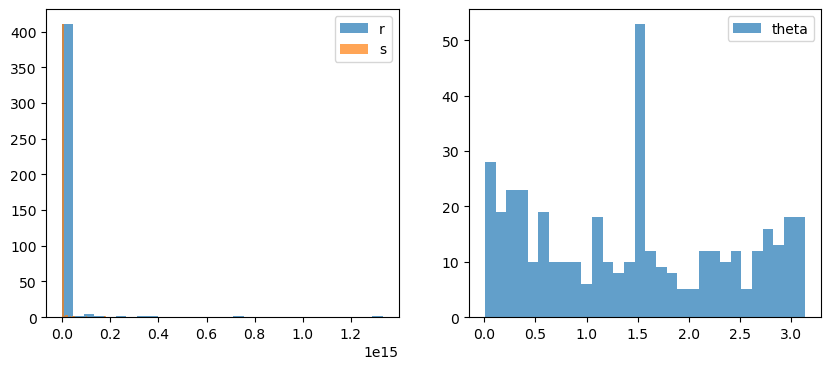


示例样本 (x1,y1,z1, x2,y2,z2, x3,y3,z3):
[ 1.24178071  0.          0.          0.74339166  1.34777648  0.
 -1.98517237 -1.34777648  0.        ]


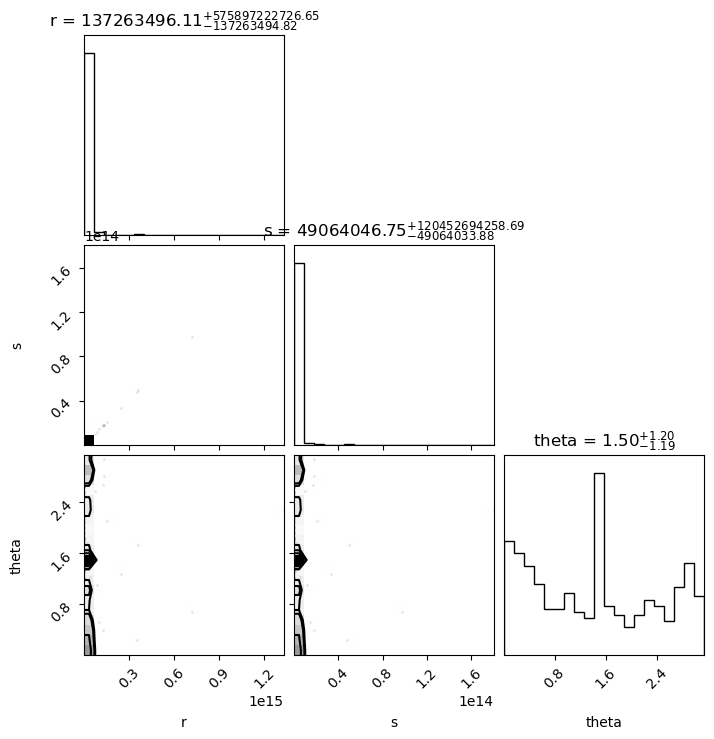

In [10]:
config = {
        'n_walkers': 8,     # 建议设置为2-4倍参数维度
        'n_steps': 1000,      # 每个walker的步数
        'burn_in': 200,       # 预烧期步数
        'data_dir': '/home/mengzhu/mywork/He3_Au_work/data'  # 修改为您的数据路径
    }
    
# 运行采样
samples, sampler = run_mcmc_sampling(**config)

# 诊断采样效果
print(f"平均接受率: {np.mean(sampler.acceptance_fraction):.2f}")
plot_results(samples)

# 转换为笛卡尔坐标并保存
cartesian_samples = spherical_to_cartesian(samples)
# np.save('he3_samples_full.npy', cartesian_samples)
# print(f"保存了 {len(cartesian_samples)} 个样本坐标到 he3_samples_full.npy")

# 示例: 访问第一个样本的三个粒子坐标
print("\n示例样本 (x1,y1,z1, x2,y2,z2, x3,y3,z3):")
print(cartesian_samples[0])

In [13]:
cartesian_samples[:,2]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.